In [1]:
import os
import shutil
import sys
import platform
sys.path.append('./../')

from pyNN.utility.build import compile_nmodl

if platform.system() == 'Linux':
    shutil.copyfile('./../src/mn.mod','./../modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.mod')
    shutil.copyfile('./../src/muscle_unit.mod','./../modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/muscle_unit.mod')
    shutil.copyfile('./../src/muscle_unit_calcium.mod','./../modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/muscle_unit_calcium.mod')
    shutil.copyfile('./../src/gammapointprocess.mod','./../modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/gammapointprocess.mod')
    compile_nmodl('./../modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/')
    # h.nrn_load_dll('./../modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.o')
if platform.system() == 'Windows':
    shutil.copyfile('../src/mn.mod','../modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.mod')
    shutil.copyfile('./../src/muscle_unit.mod','./../modelpynn/Lib/site-packages/pyNN/neuron/nmodl/muscle_unit.mod')
    shutil.copyfile('./../src/muscle_unit_calcium.mod','./../modelpynn/Lib/site-packages/pyNN/neuron/nmodl/muscle_unit_calcium.mod')
    shutil.copyfile('../src/gammapointprocess.mod','../modelpynn/Lib/site-packages/pyNN/neuron/nmodl/gammapointprocess.mod')
    compile_nmodl('../modelpynn/Lib/site-packages/pyNN/neuron/nmodl')
    h.nrn_load_dll('modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.o')


import matplotlib.pyplot as plt
import numpy as np
import pyNN
import pyNN.neuron as sim
import pyNN.space as space


from neuroml import Morphology, Segment, Point3DWithDiam as P
from neuron import h, nrn, hclass
from pyNN import neuron
from pyNN.models import BaseCellType
from pyNN.morphology import NeuroMLMorphology, NeuriteDistribution, Morphology as Morph, IonChannelDistribution
from pyNN.neuron import NativeCellType
from pyNN.neuron.cells import RandomSpikeSource, _new_property
from pyNN.neuron.morphology import uniform, random_section, random_placement, at_distances, apical_dendrites, dendrites, centre
from pyNN.neuron.simulator import state
from pyNN.parameters import IonicSpecies
from pyNN.random import RandomDistribution, NumpyRNG
from pyNN.space import Grid2D, RandomStructure, Sphere
from pyNN.standardmodels import StandardIonChannelModel, build_translations, StandardCellType, StandardModelType
from pyNN.standardmodels.cells import SpikeSourceGamma, MultiCompartmentNeuron as mc

from pyNN.utility.plotting import Figure, Panel
import src.Classes as Classes
import src.funçoes as funçoes
from src.funçoes import neuromuscular_system, soma_força
%matplotlib widget

nrnivmodl found at /media/rnwatanabe/Data/Renato/Modelo-Motoneuronio/modelpynn/bin/nrnivmodl
Successfully compiled NEURON extensions.


/media/rnwatanabe/Data/Renato/Modelo-Motoneuronio/modelpynn/lib/python3.10/site-packages/pyNN/neuron/__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")


In [2]:
timestep = 0.05
sim.setup(timestep=timestep)
Tf = 1000
n = 100
somas = funçoes.create_somas(n)
dends = funçoes.create_dends(n,somas)

In [3]:
cell_type = Classes.cell_class(
    morphology= funçoes.soma_dend(somas, dends) ,
    cm=1,    # mF / cm**2
    Ra=0.070, # ohm.mm
    ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
    pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
    pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
    na = {"conductance_density": uniform('soma', 10), "vt":list(np.linspace(-57.65, -53,100))},
    kf = {"conductance_density": uniform('soma', 1), "vt":list(np.linspace(-57.65, -53,100))},
    ks = {"conductance_density": uniform('soma', 0.5), "vt":list(np.linspace(-57.65, -53,100))},
    syn={"locations": centre('dendrite'),
         "e_syn": 0,
         "tau_syn": 0.6},  
)

In [4]:
cells = sim.Population(n, cell_type, initial_values={'v': list(-70*np.ones(n))})


cell_class(<parameters>)


In [5]:
muscle_units, force_objects, neuromuscular_junctions = neuromuscular_system(cells, n, calcium=True)

In [6]:
np.random.seed(26278342)
spike_source = sim.Population(400, Classes.SpikeSourceGammaStart(alpha=1)) 
                                                        #start=RandomDistribution('uniform', [0, 3.0], rng=NumpyRNG(seed=4242))))
syn = sim.StaticSynapse(weight=0.6, delay=0.2)
# nmj = sim.StaticSynapse(weight=1, delay=0.2)
input_conns = sim.Projection(spike_source, cells, 
                             sim.FixedProbabilityConnector(0.3, location_selector='dendrite'), 
                             syn, receptor_type="syn")


SpikeSourceGammaStart(<parameters>)


In [7]:
spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record('v', locations=('dendrite','soma'))
cells[0:2].record(('na.m', 'na.h'), locations='soma')
cells[0:2].record(('kf.n'), locations='soma')
cells[0:2].record(('ks.p'), locations='soma')
f = dict()
cat = dict()
for i in range(n):
    f[i] = h.Vector().record(force_objects[i]._ref_F)
    cat[i] = h.Vector().record(force_objects[i]._ref_CaT)


In [8]:
# soma_força(force_objects, 100)
# f, força_total = soma_força(force_objects,100)

In [9]:
sim.run(Tf, callbacks=[Classes.SetRate(spike_source, cells)])

999.9999999993644

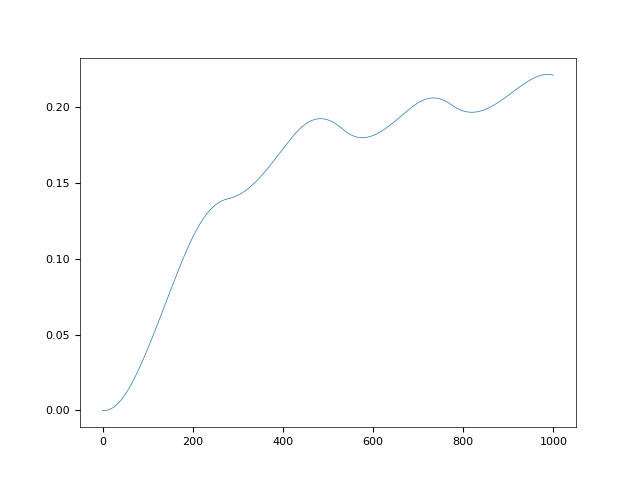

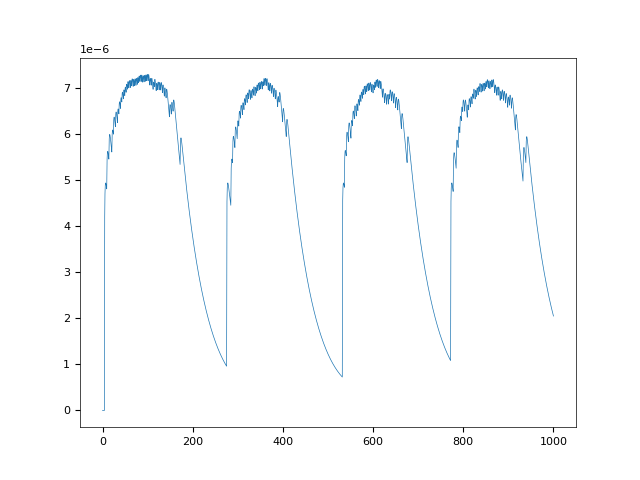

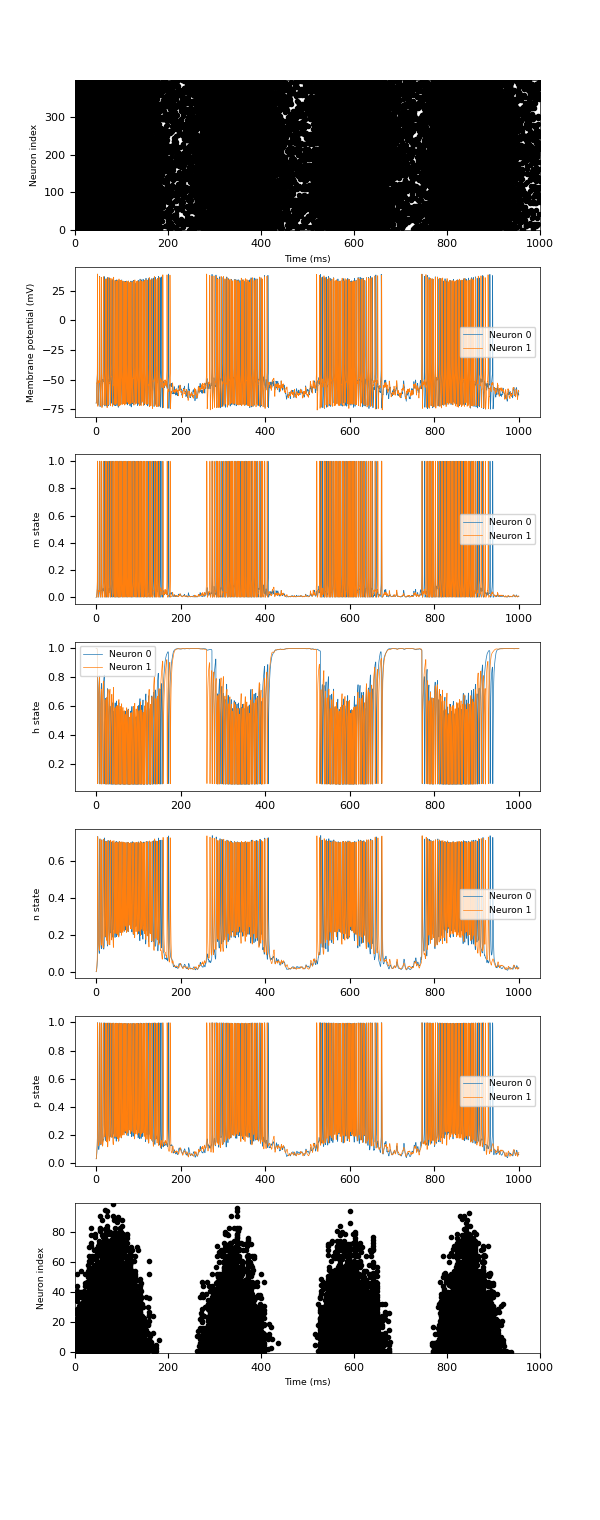

In [10]:
figure_filename = 'teste.png'
data_source = spike_source.get_data().segments[0]
data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]
# ina = data.filter(name="soma.na.ina")[0]
# ik = data.filter(name="ik")[0]

# gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(data_source.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    # Panel(ina, ylabel="i_na (mA)", xticks=True, yticks=True),
    # Panel(ik, ylabel="i_k (mA)", xticks=True, yticks=True),
    
    # Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)


plt.figure()
plt.plot(np.arange(0, Tf+timestep, timestep), f[0])
plt.show()

plt.figure()
plt.plot(np.arange(0, Tf+timestep, timestep), cat[0])
plt.show()


In [11]:
data.spiketrains[0].as_array()

array([  3.2 ,   8.2 ,  12.95,  19.5 ,  22.95,  27.4 ,  31.95,  35.2 ,
        38.75,  41.7 ,  45.1 ,  48.25,  51.25,  54.15,  57.3 ,  60.55,
        63.5 ,  66.85,  69.95,  73.1 ,  76.1 ,  78.95,  81.85,  84.9 ,
        88.1 ,  91.1 ,  94.05,  97.  , 100.05, 103.9 , 107.05, 111.05,
       113.8 , 117.9 , 121.05, 124.5 , 127.9 , 131.8 , 135.95, 139.9 ,
       147.25, 151.4 , 155.4 , 170.9 , 274.05, 283.4 , 287.25, 292.45,
       297.55, 301.1 , 304.85, 309.  , 312.6 , 316.  , 319.65, 322.85,
       326.8 , 330.3 , 333.5 , 337.25, 340.35, 343.45, 346.7 , 349.9 ,
       353.3 , 355.95, 359.15, 362.4 , 366.45, 370.  , 373.85, 378.  ,
       382.1 , 387.35, 390.55, 398.35, 406.35, 530.65, 535.2 , 539.35,
       544.1 , 549.85, 553.4 , 557.3 , 561.65, 565.25, 568.55, 571.95,
       575.25, 578.3 , 581.8 , 584.9 , 588.2 , 591.5 , 595.25, 598.9 ,
       601.75, 604.7 , 607.85, 611.35, 614.8 , 619.75, 624.45, 628.7 ,
       632.7 , 635.7 , 639.9 , 644.2 , 649.05, 653.7 , 661.7 , 674.4 ,
      